<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/multi_wavelength_rcwa_metalens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are continously working to optimize repository size and structure. 

In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

Updated git hooks.
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 2719, done.
remote: Counting objects: 100% (738/738), done.
remote: Compressing objects: 100% (487/487), done.
remote: Total 2719 (delta 258), reused 683 (delta 238), pack-reused 1981
Receiving objects: 100% (2719/2719), 754.33 MiB | 28.74 MiB/s, done.
Resolving deltas: 100% (838/838), done.
Updating files: 100% (505/505), done.
Filtering content: 100% (17/17), 77.15 MiB | 55.21 MiB/s, done.


In [ ]:
%cd /content/DFlat
!python setup.py develop

/content/DFlat
running develop
running egg_info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/DFlat.egg-link (link to .)
DFlat 2.3.0 is already the active version in easy-install.pth

Installed /content/DFlat
Processing dependencies for DFlat==2.3.0
Finished processing dependencies for DFlat==2.3.0


In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create a general optimization pipeline using the psf layer and the rcwa optical model 

A general class like this may be reused/recalled with different inputs or even different loss functions. It is a useful starting point when designing an optimization graph. 

First, we import the required modules from the DFlat repository. These contain packaged routines that are compatible with tf.keras

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import dflat.data_structure as df_struct
import dflat.optimization_helpers as df_optimizer
import dflat.physical_optical_layer as df_physical
import dflat.fourier_layer as df_fourier
import dflat.tools as df_tools
import dflat.plot_utilities as plt_util

from dflat.physical_optical_layer.core.ms_parameterization import generate_cell_perm


We first build an optimization class inheriting from the df_optimizer.Pipeline_Object (although you can choose to not use this).

By inheriting this class, all the details of saving and loading custom model checkpoints are taken care of. Moreover, this class allows us to use convenient, pre-written functions for training loops, enabling faster prototyping.  

Most of the lines below are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process when using the training helpers in the df_optimizer module! Defining this function overides the parent empy function and is entirely optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()

In [ ]:

class pipeline_metalens_rcwa(df_optimizer.Pipeline_Object):
    def __init__(self, rcwa_parameters, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_metalens_rcwa, self).__init__(savepath, saveAtEpochs)

        self.rcwa_parameters = rcwa_parameters
        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        self.cell_parameterization = "coupled_rectangular_resonators"
        self.rcwa_latent_layer = df_physical.RCWA_Latent_Layer(self.rcwa_parameters, self.cell_parameterization)
        self.psf_layer = df_fourier.PSF_Layer(propagation_parameters)

        # Make uniform state latent tensor as initial variable for metasurface with helper function
        input_shape = self.rcwa_latent_layer.shape_vect_size
        init_latent = tf.random.uniform(shape=input_shape) - 0.25
        self.latent_tensor_variable = tf.Variable(init_latent, trainable=True, dtype=tf.float32)

    def __call__(self):
        out = self.rcwa_latent_layer(self.latent_tensor_variable)
        psf_intensity, _ = self.psf_layer(out, self.point_source_locs, batch_loop=False)

        # sum over the two polarization basis (x and y linear)
        psf_intensity = tf.reduce_sum(psf_intensity, axis=1)

        # Save the last lens and psf for plotting later
        self.last_lens = out
        self.last_psf = psf_intensity

        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto):
        # This overrides the baseclass visualization call function, called during checkpoints
        savefigpath = self.savepath + "/trainingOutput/"

        # Get parameters for plotting
        # Helper call that returns simple definition of cartesian axis on lens and output space (um)
        xl, yl = plt_util.get_lens_pixel_coordinates(self.propagation_parameters)
        xd, yd = plt_util.get_detector_pixel_coordinates(self.propagation_parameters)
        xl, yl = xl * 1e6, yl * 1e6
        xd, yd = xd * 1e6, yd * 1e6

        Lx = self.rcwa_parameters["Lx"]
        Ly = self.rcwa_parameters["Ly"]
        sim_wavelengths = self.propagation_parameters["wavelength_set_m"]
        num_wl = len(sim_wavelengths)

        ### Display the learned phase and transmission profile on first row
        # and wavelength dependent PSFs on the second
        trans = self.last_lens[0]
        phase = self.last_lens[1]

        fig = plt.figure(figsize=(25, 10))
        ax = plt_util.addAxis(fig, 2, num_wl)
        for i in range(num_wl):
            ax[i].plot(xl, phase[i, 0, 0, :], "k-")
            ax[i].plot(xl, phase[i, 1, 0, :], "b-")
            # ax[i].plot(xl, trans[i, 0, 0, :], "k*")
            # ax[i].plot(xl, trans[i, 1, 0, :], "b*")
            plt_util.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Lens radius (um)",
                ylabel="Phase (x and y polarized)" if i == 0 else "",
                title=f"wavelength {sim_wavelengths[i]*1e9:3.0f} nm",
                fontsize_text=12,
                fontsize_title=12,
                fontsize_ticks=12,
            )

            ax[i + num_wl].imshow(self.last_psf[i, 0, :, :], extent=(min(xd), max(xd), min(yd), max(yd)))
            plt_util.formatPlots(
                fig,
                ax[i + num_wl],
                None,
                xlabel="det x (um)",
                ylabel="det y (um)",
                title=f"Pol. avg PSF {sim_wavelengths[i]*1e9:3.0f} nm",
                setAspect="equal",
                fontsize_text=12,
                fontsize_title=12,
                fontsize_ticks=12,
            )
        #plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Lens.png")
        #plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Lens.pdf")
        #plt.close()

        ### Display some of the learned metacells
        # We want to assemble the cell's dielectric profile so we can plot it
        latent_tensor_state = self.latent_tensor_variable
        norm_shape_param = df_tools.latent_to_param(latent_tensor_state)
        ER, _ = generate_cell_perm(norm_shape_param, self.rcwa_parameters, self.cell_parameterization)
        disp_num = 5
        cell_idx = np.linspace(0, ER.shape[1] - 1, disp_num).astype(int)

        fig = plt.figure(figsize=(25, 5))
        ax = plt_util.addAxis(fig, 1, disp_num)
        for i, idx in enumerate(cell_idx):
            ax[i].imshow(np.abs(ER[0, idx, 0, 0, :, :]), extent=(0, np.max(Lx) * 1e9, 0, np.max(Ly) * 1e9))
            plt_util.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Cell x (nm)",
                ylabel="Cell y (nm)" if i == 0 else "",
                title="Lens r (um): " + f"{xl[idx]:3.0f}",
                fontsize_text=12,
                fontsize_title=12,
                fontsize_ticks=12,
            )
        #plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Cells.png")
        #plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Cells.pdf")
        #plt.close()
        plt.show()
        return

# Define Simulation Settings and run the optimization

We can now create a function that initializes our simulation setting and passes it to the newly initialized optimization pipeline. 

This pipeline can be trained easily since it is compatible with DFlats df_optimizer.run_pipeline_optimization() routine. This routine takes in a class that inherits df_optimizer.Pipeline_Object like done above.  

To train with this call, we define a loss function. Below, this is done in loss_fn. Note that currently when using this approach, the loss function can only take "pipeline_output" as an input! This means that the loss function should be defined explicitly in terms of the pipeline call function (or be defined inside the call function) so the output is the loss value itself).  

In many cases, you may want to write your own gradient descent training routine. You can learn how to do this by opening the code file and seeing how it is done in the run_pipeline_optimization call. 

Having a routine like this just helps with rapid design and testing


In [ ]:
def run_broadband_metalens(num_epochs=50, try_gpu=True):
  # Define save path
    savepath = "examples/output/multi_wavelength_rcwa_metalens_design/"
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    # Define Fourier parameters
    wavelength_list = [400e-9, 500e-9, 600e-9, 700e-9]
    point_source_locs = np.array([[0, 0, 1e6]])
    propagation_parameters = df_struct.prop_params(
        {
            "wavelength_set_m": wavelength_list,
            "ms_samplesM": {"x": 255, "y": 255},
            "ms_dx_m": {"x": 5 * 350e-9, "y": 5 * 350e-9},
            "radius_m": None,
            "sensor_distance_m": 1e-3,
            "initial_sensor_dx_m": {"x": 2e-6, "y": 2e-6},
            "sensor_pixel_size_m": {"x": 2e-6, "y": 2e-6},
            "sensor_pixel_number": {"x": 256, "y": 256},
            "radial_symmetry": True,
            "diffractionEngine": "fresnel_fourier",
            ### Optional keys
            "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
            "manual_upsample_factor": 1,  # Otherwise you can manually dictate upsample factor
        },
        verbose=True,
    )
    gridshape = propagation_parameters["grid_shape"]

    # Define RCWA parameters
    fourier_modes = 5
    rcwa_parameters = df_struct.rcwa_params(
        {
            "wavelength_set_m": wavelength_list,
            "thetas": [0.0 for i in wavelength_list],
            "phis": [0.0 for i in wavelength_list],
            "pte": [1.0 for i in wavelength_list],
            "ptm": [1.0 for i in wavelength_list],
            "pixelsX": gridshape[2],
            "pixelsY": gridshape[1],
            "PQ": [fourier_modes, fourier_modes],
            "Lx": 350e-9,
            "Ly": 350e-9,
            "L": [600.0e-9],
            "Lay_mat": ["Vacuum"],
            "material_dielectric": "TiO2",
            "er1": "SiO2",
            "er2": "Vacuum",
            "Nx": 256,
            "Ny": 256,
            "batch_wavelength_dim": False,
        }
    )

    ## Call optimization pipeline
    saveAtEpochs=10
    pipeline = pipeline_metalens_rcwa(rcwa_parameters, propagation_parameters, point_source_locs, savepath, saveAtEpochs=saveAtEpochs)
    #pipeline.customLoad()  # Call to reload model checkpoint from savefile

    ## Define custom Loss function (Should always have pipeline_output as the function input if use helper)
    # You can write your own training function to for more control
    sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
    cidx_y = sensor_pixel_number["y"] // 2
    cidx_x = sensor_pixel_number["x"] // 2

    def loss_fn(pipeline_output):
        return -tf.reduce_sum(pipeline_output[:, 0, cidx_y, cidx_x])

    learning_rate = 2e-1
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    df_optimizer.run_pipeline_optimization(pipeline, optimizer, num_epochs=num_epochs, loss_fn=loss_fn, allow_gpu=True)

    return


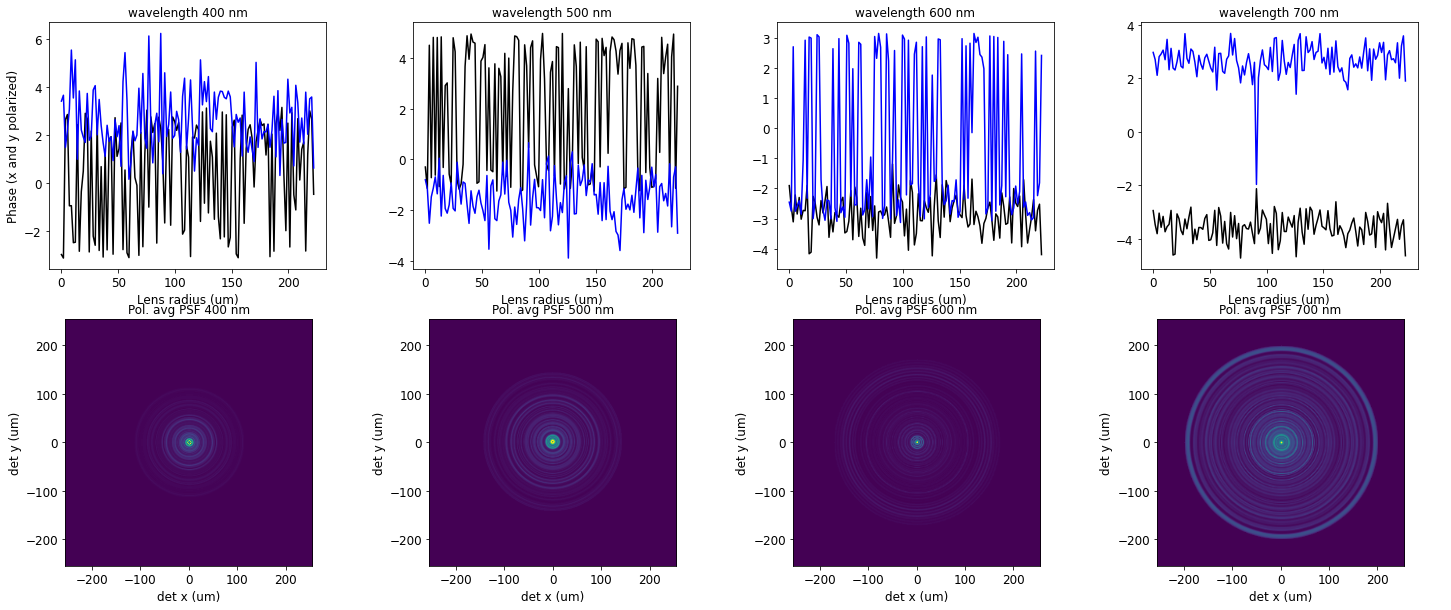

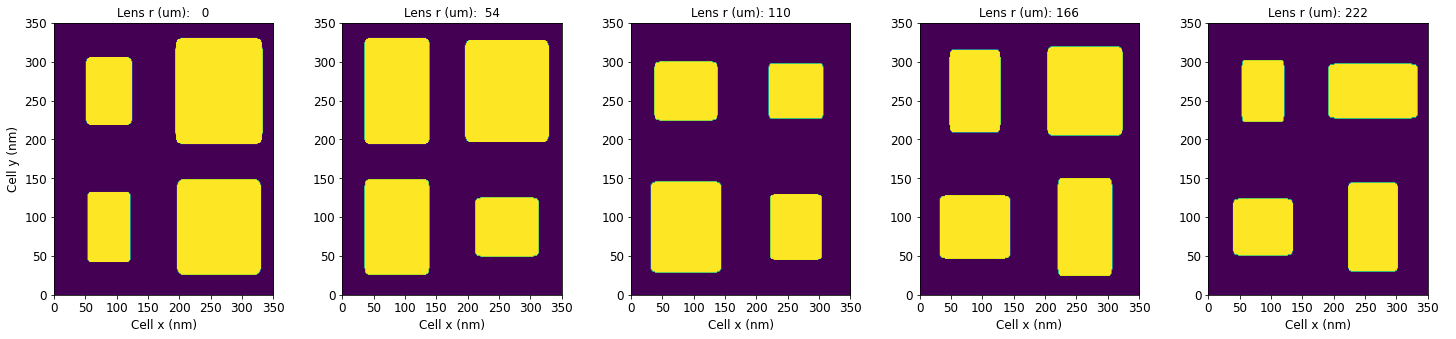

Training Log | (Step, time, loss):  0 8.511274337768555 -0.004250724373741624
Training Log | (Step, time, loss):  1 6.701141595840454 -0.030364089161713917
Training Log | (Step, time, loss):  2 6.780194282531738 -0.053284680201973536
Training Log | (Step, time, loss):  3 6.712776184082031 -0.06719811457580199
Training Log | (Step, time, loss):  4 6.689270973205566 -0.07769734733050279
Training Log | (Step, time, loss):  5 7.123217582702637 -0.08267753551161774
Training Log | (Step, time, loss):  6 6.69977068901062 -0.08208801657448153
Training Log | (Step, time, loss):  7 6.677285194396973 -0.08612784629231099
Training Log | (Step, time, loss):  8 6.711987257003784 -0.0865335080704861
Training Log | (Step, time, loss):  9 6.685030937194824 -0.08257554558587148
Log Training at step: 10


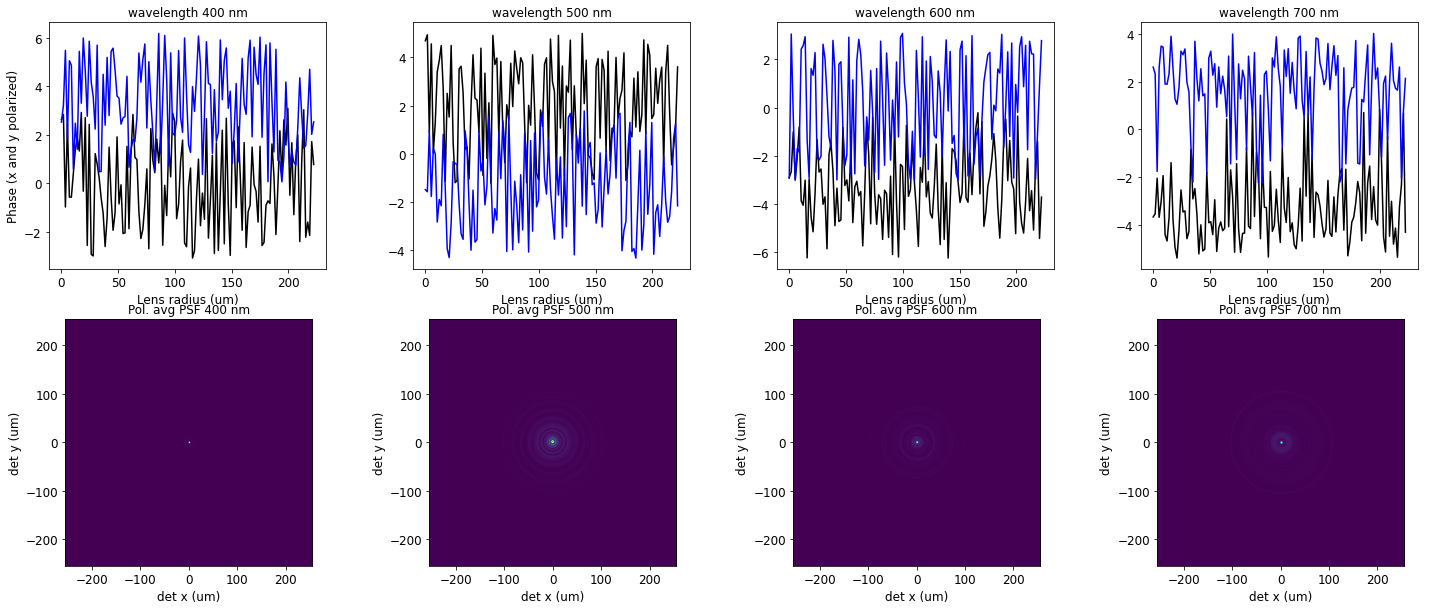

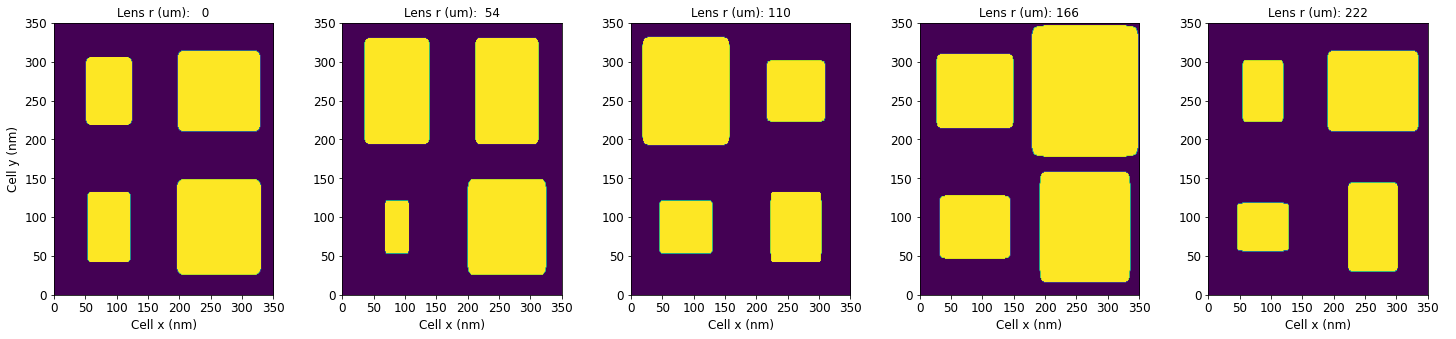

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  10 6.8015735149383545 -0.07914033970503292
Training Log | (Step, time, loss):  11 7.142979145050049 -0.07187630137242695
Training Log | (Step, time, loss):  12 6.7086029052734375 -0.06896769013289102
Training Log | (Step, time, loss):  13 6.680603504180908 -0.06822635504382815
Training Log | (Step, time, loss):  14 6.653941869735718 -0.05967165622535576
Training Log | (Step, time, loss):  15 6.6972997188568115 -0.0641339771853263
Training Log | (Step, time, loss):  16 6.678568363189697 -0.0568378955405385
Training Log | (Step, time, loss):  17 6.9276814460754395 -0.057093188005365655
Training Log | (Step, time, loss):  18 6.715522289276123 -0.0573860048280522
Training Log | (Step, time, loss):  19 6.684681415557861 -0.06103653119737956
Log Training at step: 20


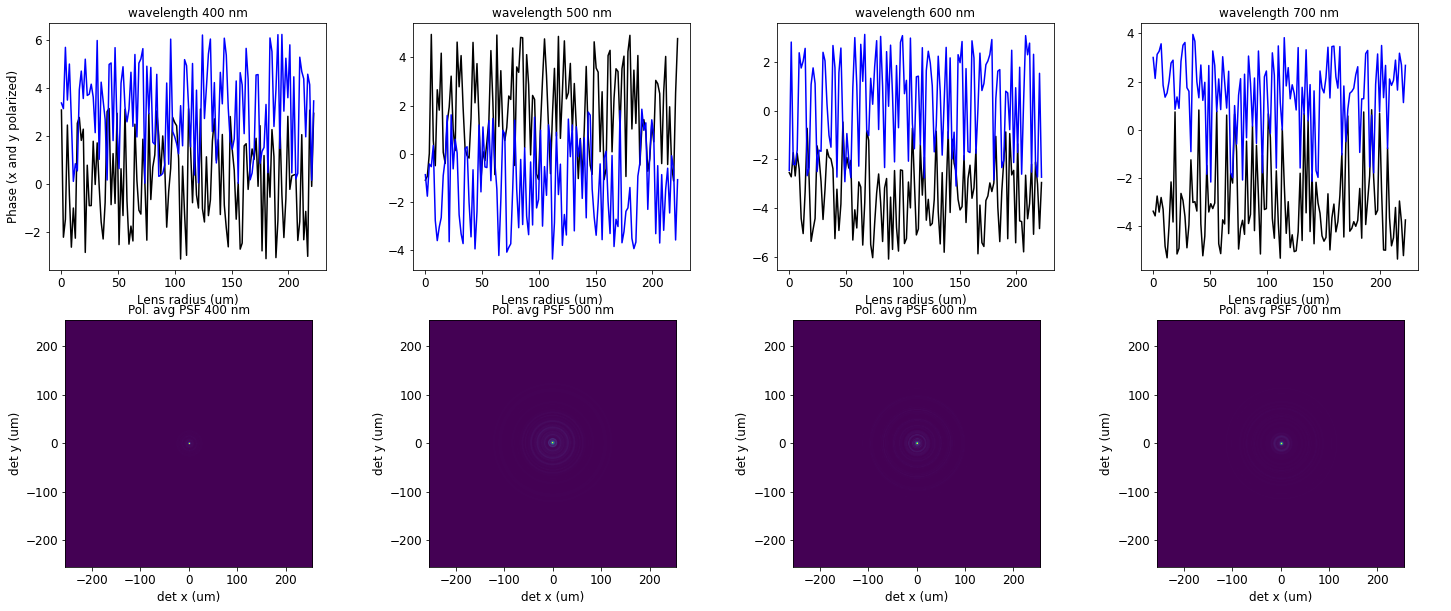

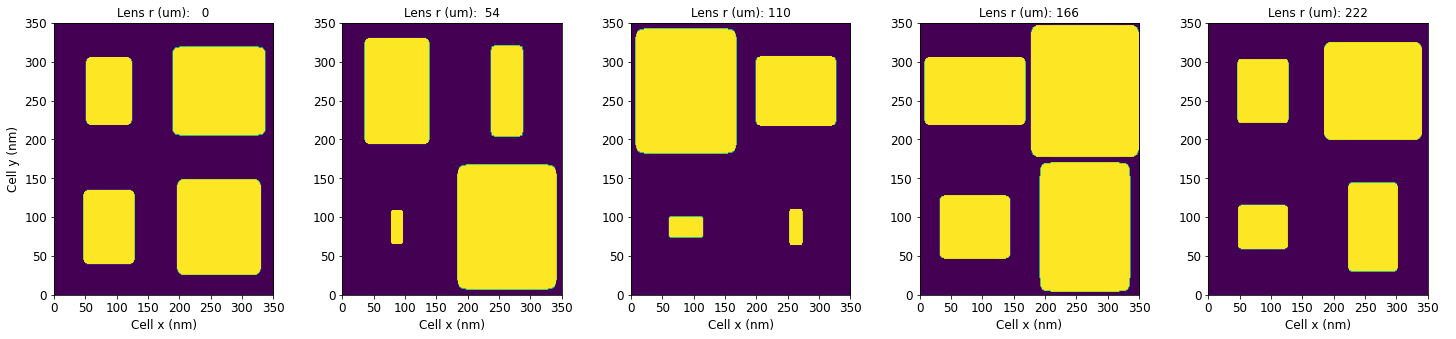

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  20 6.71748161315918 -0.06132400908172256
Training Log | (Step, time, loss):  21 6.889069557189941 -0.06423413439951901
Training Log | (Step, time, loss):  22 6.600736856460571 -0.07012883795675236
Training Log | (Step, time, loss):  23 6.68972373008728 -0.07405850524080357
Training Log | (Step, time, loss):  24 6.877550840377808 -0.07956767913607027
Training Log | (Step, time, loss):  25 6.5861217975616455 -0.07881495798528756
Training Log | (Step, time, loss):  26 6.63129448890686 -0.07562116597333875
Training Log | (Step, time, loss):  27 6.602967023849487 -0.07384594004439203
Training Log | (Step, time, loss):  28 6.672913312911987 -0.07639615816333267
Training Log | (Step, time, loss):  29 6.7037787437438965 -0.07847491385778507
Log Training at step: 30


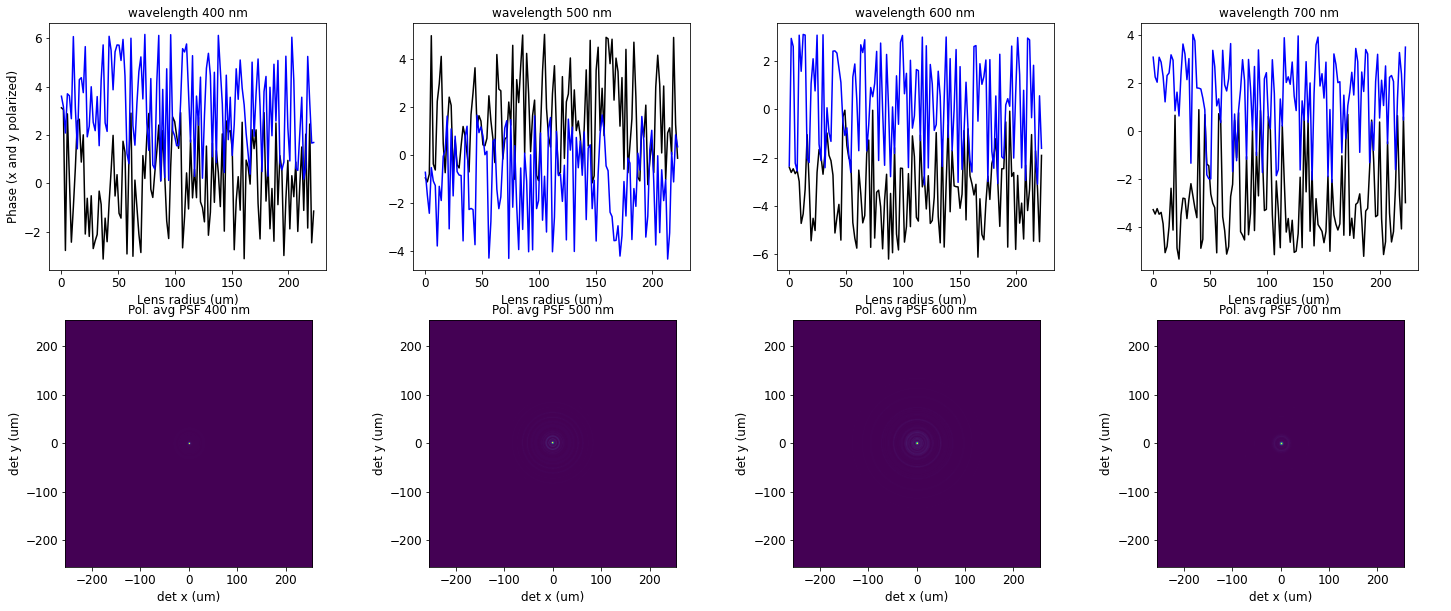

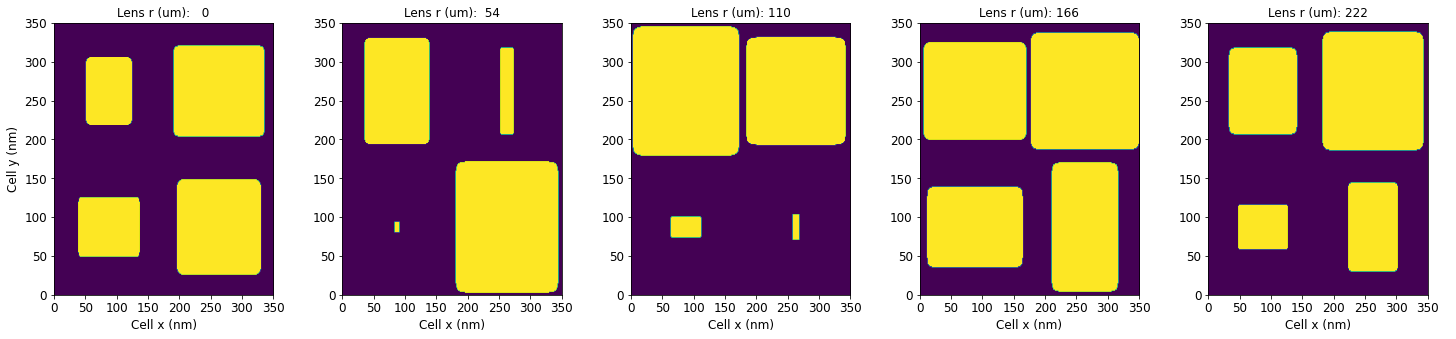

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  30 6.683450222015381 -0.07873706131004495
Training Log | (Step, time, loss):  31 6.665245771408081 -0.08370126179688706
Training Log | (Step, time, loss):  32 6.649586200714111 -0.0870400709364414
Training Log | (Step, time, loss):  33 6.707125186920166 -0.09269413834544293
Training Log | (Step, time, loss):  34 6.63869571685791 -0.10001987546355101
Training Log | (Step, time, loss):  35 6.661271810531616 -0.10440272367872713


In [ ]:
run_broadband_metalens(num_epochs=50, try_gpu=True)